In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Knowledge Graphs Course/SpEL.zip" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/SpEL_base.zip" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/UniNER.zip" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/chosen_ids.txt" .
!cp "/content/drive/MyDrive/Knowledge Graphs Course/Signal_1M.zip" .

In [ ]:
! unzip -q "/content/UniNER.zip"
! unzip -q "/content/SpEL.zip"
! unzip -q "/content/SpEL_base.zip"
! unzip -q "./Signal_1M.zip"

In [ ]:
CHOSEN_IDS_PATH = "/content/chosen_ids.txt"
PRONOUNS = ["i", "you", "he", "she", "it", "we", "they", "him", "her", "his"]

##utils

In [ ]:
import nltk
nltk.download("punkt")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def plot(frequencies, categories, xlabel, title, path):
    import matplotlib.pyplot as plt

    # Fixing random state for reproducibility

    fig, ax = plt.subplots()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Example data
    y_pos = list(range(len(categories)))
    fig.set_size_inches(5, 7)
    ax.barh(y_pos, frequencies, label=frequencies, align='center', color=colors)
    ax.set_yticks(y_pos, labels=categories)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    for i, v in enumerate(frequencies):
        ax.text(v, i, str(v), color='black', verticalalignment='center', fontsize="xx-small", horizontalalignment="right")
    fig.savefig(path, bbox_inches="tight", pad_inches=0.1)

In [ ]:
import os
import json
from tqdm import tqdm
import random
def get_filenames(dir_path, chosen_ids_path):
    file_names=[]
    id2idx={}
    i=0
    ids = []
    with open(chosen_ids_path, "r") as f:
        ids = f.readlines()
        ids = [id.strip() for id in ids]

    for id in ids:
        id2idx[id] = len(file_names)
        path = os.path.join(dir_path, id)
        file_names.append((path, id))
    return file_names, id2idx

def read_file(file_name):
    file_jason = open(file_name, encoding="utf-8")
    file_jason = json.load(file_jason)
    return(file_jason)

per_filenames, id2idx_per = get_filenames("/content/UniNER/PER", CHOSEN_IDS_PATH)
spel_filenames, id2idx_spel = get_filenames("/content/SpEL_base/", CHOSEN_IDS_PATH)
signal_filenames, id2idx_signal = get_filenames("/content/Signal_1M/", CHOSEN_IDS_PATH)

## Entity matching without cleaning

In [ ]:
NER_filenames = per_filenames

In [ ]:
import re
import pandas as pd
def is_special_case(entity:str):
    return "*" in entity or "?" in entity or "\\u" in entity or "+" in entity

def get_offsets(entity, sentence):
    if entity.lower() in PRONOUNS:
        entity = " " + entity.lower() + " "
    else:
        entity = f"{entity.lower()}"
    return [(m.start()-1, m.end()-1) for m in re.finditer(entity, sentence.lower())]

def match_entities_in_sentence(ner_output, spel_output, sentence, ignore_func):
    matches = 0
    failures = []
    total_checked = 0
    for named_entity in ner_output:
        if is_special_case(named_entity) or ignore_func(named_entity):
            continue
        try:
            offsets = get_offsets(named_entity, sentence)
            matches_found = 0
            for u, v in offsets:
                for mention in spel_output:
                    start, end = tuple(mention["span"])
                    if max(u, start) <= min(v, end):
                        matches_found += 1
                        break

            total_checked += len(offsets)
            if matches_found == 0:
                failures.append({"Named Entity": named_entity, "Sentence" : sentence, "Spel": spel_output})
            else:
                 matches += matches_found
        except Exception as e:
            print(e, named_entity, "|||||", sentence)
            pass

    return matches, total_checked, failures

def match_entities_in_datasets(ignore_func=lambda ne: False):
    total_matches = 0
    total_entities = 0
    not_found = []
    for idx in tqdm(range(len(NER_filenames))):
        ner_out = read_file(NER_filenames[idx][0])
        spel_out = read_file(spel_filenames[idx][0])
        for i, sent in enumerate(nltk.sent_tokenize(read_file(signal_filenames[idx][0])["content"])):
            matches_count, total_checked, failures = match_entities_in_sentence(ner_out[i], spel_out[i], sent, ignore_func)
            not_found.extend(failures)
            total_matches += matches_count
            total_entities += total_checked


    # df = pd.DataFrame(not_found)
    # df.to_csv("persons_not_found.csv", index=False)
    return total_entities, total_matches, not_found

total_entities, total_matches, not_found = match_entities_in_datasets()

  0%|          | 289/100000 [00:01<07:05, 234.50it/s]


KeyboardInterrupt: 

In [ ]:
total_matches

272347

In [ ]:
total_matches / total_entities

0.29490358544339434

In [ ]:
total_matches

272347

In [ ]:
total_entities

923512

##Entity Matching with cleaning

In [ ]:
lower_case_names = []
lower_case_freqs = {}
non_lower_freqs = {}
ids = []

total_name_entities = 0
for fn, f_id in tqdm(NER_filenames):
    doc_names = read_file(fn)
    sents = nltk.sent_tokenize(read_file(signal_filenames[id2idx_signal[f_id]][0])["content"])
    for i, snt_names in enumerate(doc_names):
        for name in snt_names:
            if name == "":
                continue
            try:
                occurences = get_offsets(name, sents[i])
            except Exception as e:
                occurances = []
            total_name_entities += len(occurences)

            if name.islower() or name.lower() in PRONOUNS:
                name = name.lower()
                lower_case_names.append((name, f_id))
                lower_case_freqs[name] = lower_case_freqs.get(name, 0) + len(occurences)
            else:
                name = name.lower()
                non_lower_freqs[name] = non_lower_freqs.get(name, 0) + len(occurences)

100%|██████████| 100000/100000 [05:09<00:00, 323.59it/s]


In [ ]:
len(lower_case_names)

129289

In [ ]:
lower_case_freqs = {k: v for k, v in sorted(lower_case_freqs.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
sum([i[1] for i in lower_case_freqs.items() if i[1] > 1])

109690

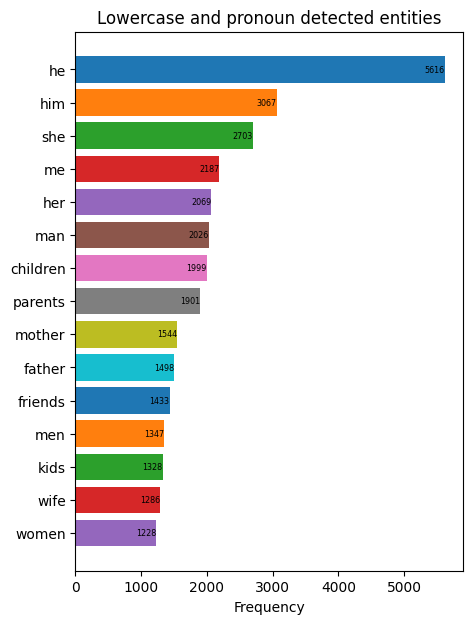

In [ ]:
most_frequent = list(lower_case_freqs.items())[:15]
categories = [i[0] for i in most_frequent]
frequencies = [i[1] for i in most_frequent]

plot(frequencies, categories, "Frequency", "Lowercase and pronoun detected entities", "1.jpg")

In [ ]:
least_frequent = [i for i in lower_case_freqs.items() if i[1] < 10 and i[1] > 1 and "@" not in i[0]]
random.seed(6556)
least_frequent = random.sample(least_frequent, k=20)

categories = [i[0] for i in least_frequent]
frequencies = [i[1] for i in least_frequent]
print(len(categories), len(frequencies))
plot(frequencies, categories, "Frequency", "Lowercase and pronoun detected entities", "2.jpg")

In [ ]:
import re
import pandas as pd
def ignore_me(entity):
    return (entity.lower() in lower_case_freqs) and (entity.lower() not in non_lower_freqs)


total_entities, total_matches, not_found = match_entities_in_datasets(ignore_func=ignore_me)

 33%|███▎      | 33139/100000 [01:15<02:10, 510.78it/s]

bad escape (end of pattern) at position 3 Dev\ ||||| CHS students who were named to the list were: John Alberse, Zachary Begland, Dhathri Bobba, Jarrad Cisco, Asutosh Dhakal, Tanvi Gupta, Inamdar Hrishikesh, Shao-Po Huang, Ayoung Jo, Ethan Judd, Tejas Kalanithi, Vinay Kalvacherla, Taeeun Kim, Daniel Koh, Raghav Kotha, Surbhi Kumar, Anna Kustar, Sydney Legee, Anushka Limaye, Pooja Marella, Joseph Overman, Sriram Palepu, Shivani Patel, Giselle Peng, Zachary Pranske, Neha Purandare, Sajani Raja, Ananya Rajesh, Surabi Rao, Vishaal Sakthivelnathan, Prinon Shahed Robert Shi, Amogh Singhal, Julia Sircar, Dev Thimmisetty and Katherine Yut.


 41%|████▏     | 41335/100000 [01:30<02:11, 445.02it/s]

unterminated character set at position 5 Jean [Asselborn ||||| And as Jean [Asselborn, Foreign Minister of Luxembourg] mentioned, we are talking here of a flow of people that in these weeks - can change - mainly consists of Syrians, Afghans, Eritreans and Iraqis.


100%|██████████| 100000/100000 [03:59<00:00, 416.81it/s]


In [ ]:
total_matches / total_entities

0.30921428197786155

In [ ]:
total_matches, total_entities

(271915, 879374)

## Cutoff

In [ ]:
non_lower_freqs = {k: v for k, v in sorted(non_lower_freqs.items(), key=lambda item: item[1], reverse=True)}
for k in non_lower_freqs:
    if k in lower_case_freqs:
        non_lower_freqs[k] += lower_case_freqs[k]

In [ ]:
non_lower_freqs

In [ ]:
CUT_OFF_PRECENTAGE = 20 #precent

In [ ]:
import re
end_idx = int(len(non_lower_freqs) * CUT_OFF_PRECENTAGE * 0.01)
cutted_off = {k:v for k, v in list(non_lower_freqs.items())[:end_idx]}
matches = {}

def match_entity(named_entity, spel_out, sentence,idx):
    try:
        offsets = get_offsets(named_entity, sentence)
        matches = 0
        for u, v in offsets:
            for mention in spel_out:
                start, end = tuple(mention["span"])
                if max(u, start) <= min(v, end):
                    matches += 1
                    break
        return matches
    except Exception as e:
        print(e, named_entity, spel_out, sentence)
        return 0

for idx in tqdm(range(len(NER_filenames))):
    ner_out = read_file(NER_filenames[idx][0])
    spel_out = read_file(spel_filenames[idx][0])
    for i, sent in enumerate(nltk.sent_tokenize(read_file(signal_filenames[idx][0])["content"])):
        for ne in ner_out[i]:
            if ne.lower() not in cutted_off:
                continue
            matched = match_entity(ne, spel_out[i], sent,NER_filenames[idx])
            matches[ne.lower()] = matches.get(ne.lower(), 0) + matched


overlap_precentage = {}
for key, value in cutted_off.items():
    overlap_precentage[key] = min(1, matches.get(key, 0) / value)



 50%|████▉     | 49975/100000 [01:11<01:20, 619.17it/s]

multiple repeat at position 6 Mr. A**** [] Mr. A**** said that in the spot she's in in the books that she would work 100% and only get a 10% improvement.


100%|██████████| 100000/100000 [02:35<00:00, 643.72it/s]


In [ ]:
for k in cutted_off:
    cutted_off[k] = (cutted_off[k], overlap_precentage[k])

<ipython-input-47-d804956f6df9>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5%', '10%', '15%', '20%'])


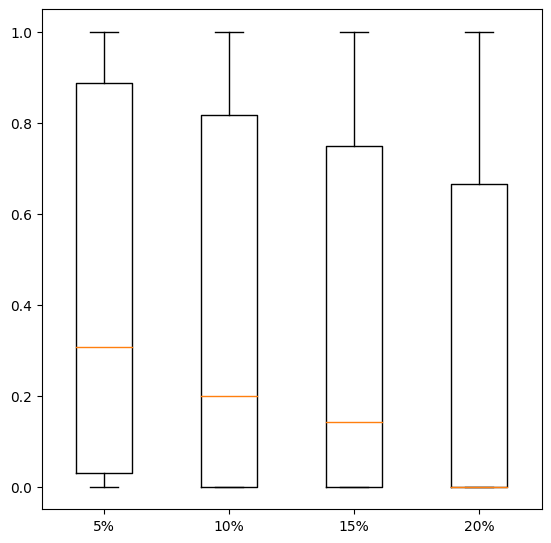

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


overlap = [i[1] for i in list(overlap_precentage.items())]
data= [
       overlap[:int(len(overlap) * 0.25)],
       overlap[:int(len(overlap) * 0.5)],
       overlap[:int(len(overlap) * 0.75)],
       overlap[:int(len(overlap) * 1)]]
fig = plt.figure(figsize =(5, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['5%', '10%', '15%', '20%'])

# Creating plot
bp = ax.boxplot(data)
# show plot
plt.show()

In [ ]:
[e for e in list(cutted_off.items())[:int(len(overlap) * 0.005)] if e[1][0]>800]

[('trump', (3623, 0.6168920783880761)),
 ('god', (3361, 0.6468313002082714)),
 ('pope francis', (2783, 0.9816744520301832)),
 ('obama', (2520, 0.6984126984126984)),
 ('jesus', (1984, 0.6592741935483871)),
 ('francis', (1790, 0.5184357541899441)),
 ('clinton', (1707, 0.8512009373169303)),
 ('donald trump', (1604, 0.9881546134663342)),
 ('davis', (1375, 0.03709090909090909)),
 ('smith', (1243, 0.008849557522123894)),
 ('narendra modi', (1214, 0.9950576606260296)),
 ('barack obama', (1167, 0.9974293059125964)),
 ('williams', (1083, 0.11449676823638043)),
 ('pope', (2011, 0.2809547488811537)),
 ('tony abbott', (952, 0.9852941176470589)),
 ('modi', (916, 0.7150655021834061)),
 ('john', (892, 0.09641255605381166)),
 ('jones', (885, 0.13220338983050847)),
 ('johnson', (882, 0.13038548752834467)),
 ('murray', (876, 0.5353881278538812)),
 ('hillary clinton', (872, 0.9862385321100917)),
 ('christ', (868, 0.4032258064516129)),
 ('malcolm turnbull', (863, 0.9942062572421785)),
 ('david cameron', (

In [ ]:
plt.savefig("per_")

<Figure size 640x480 with 0 Axes>

In [ ]:
import pickle

with open("overlap_per.pkl", "wb") as f:
    pickle.dump(overlap_precentage, f)

In [ ]:
!mv overlap_per.pkl "/content/drive/MyDrive/Knowledge Graphs Course/Overlap"

#### Universal

In [3]:
import pickle
overlap_all = []
with open("/content/drive/MyDrive/Knowledge Graphs Course/Overlap/overlap_loc.pkl", "rb") as f:
    overlap_all.extend(list(pickle.load(f).items()))

with open("/content/drive/MyDrive/Knowledge Graphs Course/Overlap/overlap_per.pkl", "rb") as f:
    overlap_all.extend(list(pickle.load(f).items()))


with open("/content/drive/MyDrive/Knowledge Graphs Course/Overlap/overlap_org.pkl", "rb") as f:
    overlap_all.extend(list(pickle.load(f).items()))

In [4]:
overlap_all = sorted(overlap_all, key=lambda pair: pair[1], reverse=True)

In [5]:
len(overlap_all)

121612

<ipython-input-10-02065547e110>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5%', '10%', '15%', '20%'])


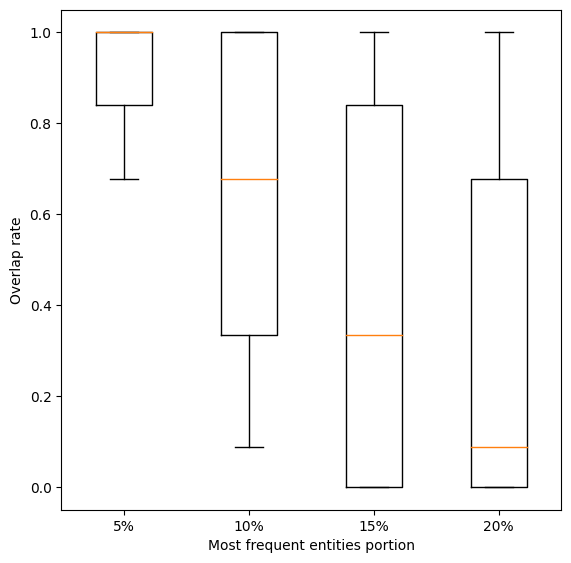

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


overlap = [i[1] for i in overlap_all]
data= [
       overlap[:int(len(overlap) * 0.25)],
       overlap[:int(len(overlap) * 0.5)],
       overlap[:int(len(overlap) * 0.75)],
       overlap[:int(len(overlap) * 1)]]
fig = plt.figure(figsize =(5, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['5%', '10%', '15%', '20%'])
ax.set_xlabel("Most frequent entities portion")
ax.set_ylabel("Overlap rate")
# Creating plot
bp = ax.boxplot(data)
# show plot
plt.show()

In [11]:
fig.savefig("cutoff.png", bbox_inches="tight", pad_inches=0.1)

In [ ]:
overlap_all[:20]

[('stamford bridge', 1.0),
 ('white hart lane', 1.0),
 ('independence hall', 1.0),
 ('san francisco bay', 1.0),
 ('milton keynes', 1.0),
 ('yankee stadium', 1.0),
 ('wrigley field', 1.0),
 ('the united states', 1.0),
 ('state of california', 1.0),
 ('greek island', 1.0),
 ('upton park', 1.0),
 ('south wales', 1.0),
 ('chukchi sea', 1.0),
 ('samos', 1.0),
 ('south australian', 1.0),
 ('louis armstrong stadium', 1.0),
 ('durrington walls', 1.0),
 ('lower manhattan', 1.0),
 ('rogers centre', 1.0),
 ('north and south america', 1.0)]

In [ ]:
overlap_all[-50:]

[('kiva systems', 0.0),
 ('nnbr', 0.0),
 ('hemfosa', 0.0),
 ('coupons and freebies mom', 0.0),
 ('solaris power cells, inc.', 0.0),
 ('grandfield pacific inc.', 0.0),
 ('noble biomaterials, inc.', 0.0),
 ('ucla pilipino alumni scholarship', 0.0),
 ('navy pier inc.', 0.0),
 ('chowhound', 0.0),
 ('pure multi-family reit lp', 0.0),
 ('silver city galleria', 0.0),
 ('taunton area chamber of commerce', 0.0),
 ('b&d construction', 0.0),
 ('bishop connolly', 0.0),
 ('ionvr', 0.0),
 ('cloud people', 0.0),
 ('ilu', 0.0),
 ('national product supply system', 0.0),
 ('npss', 0.0),
 ('npsg', 0.0),
 ('craiglewis band', 0.0),
 ('mountain faith band', 0.0),
 ('metal mulisha fitz army', 0.0),
 ('ogh', 0.0),
 ('amis oracle and java blog', 0.0),
 ('apl logistics', 0.0),
 ('pfnx', 0.0),
 ('trnx', 0.0),
 ('global endoscopy', 0.0),
 ('atlas world group, inc.', 0.0),
 ('nashville christian', 0.0),
 ('gloscon', 0.0),
 ('the american nurse', 0.0),
 ('nursing insider', 0.0),
 ('educational insights', 0.0),
 ('s